In [2]:
%matplotlib notebook
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = "/data/POL/HALOB/output_00417"
#path = "/data/POL/HALOA/output_01274"
#path = "/data/MANU/anunez/output_00690"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False)

loading Dark matter..
loading Stars..
loading Gas..


In [4]:
ok,rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)
centro_rho = myhalo.st.pos3d[np.where(rho == rho.max())][0]
print "density",centro_rho
myhalo.center_shift(centro_rho)

density [ 9685.31347656  9883.21972656  9817.79785156]


In [5]:
myhalo.r_virial(600,n=4)

starting
stackted
start histogram
 done
rotated
| r_200 = 166.9921875
| Diagonal matrix computed 
|    |19, 0, 0|
| D =| 0,14, 0|
|    | 0, 0, 2|


In [6]:
pos_dm = np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhalo.gs.pos3d.reshape(len(myhalo.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
mass = np.concatenate((myhalo.dm.mass,myhalo.st.mass,myhalo.gs.mass))
v = np.concatenate((myhalo.dm.v,myhalo.st.v,myhalo.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

42298149 42298149


In [7]:
myhalo.gs.hsml.min()

0.15194553

In [8]:
ok, acc, Phy = CF.getGravity(pos,mass,0.15,G=myhalo.p.G)

In [9]:
#r_array = np.logspace(np.log10(min_R),2*np.log10(4*myhalo.r200),100)

# virial ratio q


In [1]:
pos = np.concatenate((pos_dm, pos_st))
mass = np.concatenate((myhalo.dm.mass,myhalo.st.mass))
v = np.concatenate((myhalo.dm.v,myhalo.st.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

NameError: name 'np' is not defined

In [ ]:
inside_halo = np.where(r2<(myhalo.r200)**2)
kmtokpc = 1 / 3.08567758128e+16 
E_kin = (np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2))
               
E_therm = np.sum(myhalo.gs.temp[[(myhalo.gs.r<myhalo.r200)]] *\
                 myhalo.gs.mass[(myhalo.gs.r<myhalo.r200)]   *\
                 np.float(myhalo.p.kB/ myhalo.p.m_p))
E_pot = np.sum(mass[inside_halo]*Phy[inside_halo])

print E_kin, E_therm, 2*(E_therm+E_kin)/E_pot
q = (np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2) / np.sum(mass[inside_halo]*Phy[inside_halo])) + 1 

In [ ]:
print "q = ",q,r", numerator = ",np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2),", denominator = ",np.sum(mass[inside_halo]*Phy[inside_halo])
print "ratio = ",(np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2) / np.sum(mass[inside_halo]*Phy[inside_halo]))

In [ ]:
dm = len(myhalo.dm.mass)+len(myhalo.st.mass)
inside_halo = np.where(r2[:dm]<(myhalo.r200)**2)
kmtokpc = 1 / 3.08567758128e+16 
q = (np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2) / np.sum(mass[inside_halo]*Phy[inside_halo])) + 1 

In [ ]:
print "q = ",q,r", numerator = ",np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2),", denominator = ",np.sum(mass[inside_halo]*Phy[inside_halo])
print "ratio = ",(np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2) / np.sum(mass[inside_halo]*Phy[inside_halo]))

# Potential and Rmax 

In [9]:

bin_num = 400

pot_sph, bins_pot = np.histogram(r2,bins=bin_num,
                                 weights=Phy)
n, _ = np.histogram(r2,bins=bin_num)



In [10]:
fig, ax = plt.subplots()
ax.set_title("spherical shells",fontsize=30)
#ax.set_ylim([pot_sph.min(),np.abs(pot_sph.min())/6.])
ax.set_ylabel(r'$\Phi$ [kpc $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
#ax.set_xscale('log')
ax.set_xlabel(r'r [kpc] ', fontsize=15)
ax.plot(np.sqrt(bins_pot[1:]),pot_sph/n,'bo-')

ax.add_patch(
    patches.Rectangle((450, -1.4e-29),
        100,
        0.9e-29,
        fill=False      # remove background
    )
)


left, bottom, width, height = [0.35, 0.23, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim([450,550])
ax2.set_ylim([-1.2e-29,-0.6e-29])

ax2.set_ylabel(r'$\Phi$ [kpc $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
ax2.set_xlabel(r'r [kpc] ', fontsize=15)
ax2.plot(np.sqrt(bins_pot[1:]),pot_sph/n,'bo-')

<IPython.core.display.Javascript object>

In [11]:
pot_sph, bins_pot = np.histogram(r2,bins=np.logspace(np.log10(2),2*np.log10(4*myhalo.r200),1000),
                                 weights=Phy)
n, _ = np.histogram(r2,bins=np.logspace(np.log10(2),2*np.log10(4*myhalo.r200),1000))

In [12]:
fig, ax = plt.subplots()
ax.set_title("spherical shells",fontsize=30)
#ax.set_ylim([pot_sph.min(),np.abs(pot_sph.min())/6.])
ax.set_ylabel(r'$\Phi$ [kpc $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
#ax.set_xscale('log')
ax.set_xlabel(r'r [kpc] ', fontsize=15)
ax.plot(np.sqrt(bins_pot[1:]),pot_sph/n,'bo-')

ax.add_patch(
    patches.Rectangle((450, -1.4e-29),
        100,
        0.9e-29,
        fill=False      # remove background
    )
)


left, bottom, width, height = [0.35, 0.23, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim([450,550])
ax2.set_ylim([-1.2e-29,-0.6e-29])

ax2.set_ylabel(r'$\Phi$ [kpc $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
ax2.set_xlabel(r'r [kpc] ', fontsize=15)
ax2.plot(np.sqrt(bins_pot[1:]),pot_sph/n,'bo-')

<IPython.core.display.Javascript object>

# l.o.s story 

In [13]:
ok,rho_dm,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32), myhalo.dm.mass)

In [14]:
# center of big neighbour
neighbourg = rho_dm[np.where((myhalo.dm.r<520)&(myhalo.dm.r>480))].max()
myneighbourg = myhalo.dm.pos3d[np.where(rho_dm==neighbourg)][0]
# its radius squared
r_nei2 = myneighbourg[0]**2 + myneighbourg[1]**2 + myneighbourg[2]**2
# distance to every point proyected to the line conecting center to neigblourg 
adyacent = (pos3d[:,0]*myneighbourg[0] + pos3d[:,1]*myneighbourg[1] + pos3d[:,2]*myneighbourg[2]) / np.sqrt(r_nei2)
# distance to each point
hipoteneuse = np.sqrt(pos3d[:,0]**2 + pos3d[:,1]**2 + pos3d[:,2]**2)
# angle of cone
alpha = np.radians(5)
cos_alpha = np.cos(alpha)
# cosine of all particles respective to their angle to the l.o.s
cos_all = adyacent / hipoteneuse 
# final selection of cone
my_cone = pos3d[np.where((cos_all)>cos_alpha)]

In [15]:
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlim([-600,0])
ax.set_ylim([-320,300])

ax.scatter(my_cone[:,0], my_cone[:,2],c='r',lw=0,s=0.1,alpha=0.5)
ax.scatter(myneighbourg[0],myneighbourg[2],s=20)

<IPython.core.display.Javascript object>

# Virial radius and mass of neighbour  



In [16]:
# radii from center of neighbour
r_neig = np.sqrt((pos3d[:,0] - myneighbourg[0])**2 +(pos3d[:,1] - myneighbourg[1])**2 +(pos3d[:,2] - myneighbourg[2])**2 )
# calculating the R200 of neighbout
mhist, rhist = np.histogram(r_neig,range=(0.0,np.sqrt(r_nei2)),bins=512, weights=mass )
vol_bin = (4./3.)*np.pi*(rhist[:-1]**3)
r_bin = rhist[:-1]+ 0.5*(rhist[2]-rhist[1])
rho_s = np.cumsum(mhist) / vol_bin
r200_neigh = r_bin[np.argmin(np.abs(rho_s - (200 * myhalo.p.rho_crit)))]
# mass of neighbour
mass_neigh = np.sum(mass[np.where(r2<r200_neigh**2)])
print "the biggest neighbourg has a mass of {0:.4e} Msun and a r200 of {1:.4f} kpc".format(mass_neigh,r200_neigh)
print "and it is located at {0:.4f} kpc from de center of our halo ".format(np.sqrt(r_nei2))


the biggest neighbourg has a mass of 2.1392e+11 Msun and a r200 of 19.6061 kpc
and it is located at 514.7846 kpc from de center of our halo 


In [17]:
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlim([-600,0])
ax.set_ylim([-320,300])

ax.scatter(my_cone[:,0], my_cone[:,2],c='r',lw=0,s=0.1,alpha=0.5)
ax.scatter(myneighbourg[0],myneighbourg[2],s=20)
circle = plt.Circle(((0),(0)),myhalo.r200, color='k',lw=1, fill=False)
ax.add_patch( circle )
circle = plt.Circle(((myneighbourg[0]),(myneighbourg[2])),r200_neigh, color='k',lw=1, fill=False)
ax.add_patch( circle )

<IPython.core.display.Javascript object>

In [18]:
los_condition = np.where((cos_all)>cos_alpha)
cone_pos = my_cone
cone_mass = mass[los_condition]
cone_Phy = Phy[los_condition]
cone_r2 = my_cone[:,0]**2 + my_cone[:,1]**2 + my_cone[:,2]**2
# now the histogram
bin_num = 1000
pot_los, bins_pot_los = np.histogram(cone_r2,bins=bin_num,
                                 weights=cone_Phy)
n_los, _ = np.histogram(cone_r2,bins=bin_num)


<IPython.core.display.Javascript object>


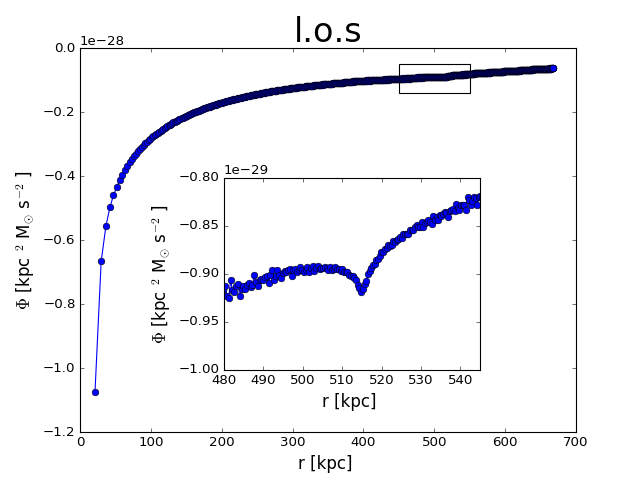

In [19]:
fig, ax = plt.subplots()
ax.set_title("l.o.s",fontsize=30)
#ax.set_ylim([pot_sph.min(),np.abs(pot_sph.min())/6.])
ax.set_ylabel(r'$\Phi$ [kpc $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
#ax.set_xscale('log')
ax.set_xlabel(r'r [kpc] ', fontsize=15)
ax.plot(np.sqrt(bins_pot_los[1:]),pot_los/n_los,'bo-')

ax.add_patch(
    patches.Rectangle((450, -1.4e-29),
        100,
        0.9e-29,
        fill=False      # remove background
    )
)


left, bottom, width, height = [0.35, 0.23, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim([480,545])
ax2.set_ylim([-1e-29,-0.8e-29])

ax2.set_ylabel(r'$\Phi$ [kpc $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
ax2.set_xlabel(r'r [kpc] ', fontsize=15)
ax2.plot(np.sqrt(bins_pot_los[1:]),pot_los/n_los,'bo-')


# $\beta$ parameter

$$\beta = 1 - \frac{ \sigma_{\phi}^2 + \sigma_{\theta}^2}{2 \sigma_{r}^2}$$

In [25]:
point_num = 300
r_beta = np.logspace(-1,np.log10(4*myhalo.r200),point_num)
vphi = np.concatenate((myhalo.dm.vphi,myhalo.st.vphi,myhalo.gs.vphi))
vtheta = np.concatenate((myhalo.dm.vtheta,myhalo.st.vtheta,myhalo.gs.vtheta))
vr = np.concatenate((myhalo.dm.vr,myhalo.st.vr,myhalo.gs.vr))

In [26]:
def beta_param(i):
    condition = np.where((r2>r_beta[i]**2)&(r2<=r_beta[i+1]**2))
    v_r = vr[condition]
    v_phi = vphi[condition]
    v_theta = vtheta[condition]
    #print (np.std(v_phi))**2 ,(np.std(v_theta))**2 , (np.std(v_r))**2  
    return 1 - ((np.std(v_phi))**2 +(np.std(v_theta))**2) / 2. / (np.std(v_r))**2  
get_beta = np.vectorize(beta_param)

In [27]:
beta_r = get_beta(range(point_num-1))

In [28]:
print len(r_beta[:-1]), len(beta_r)

299 299


<IPython.core.display.Javascript object>


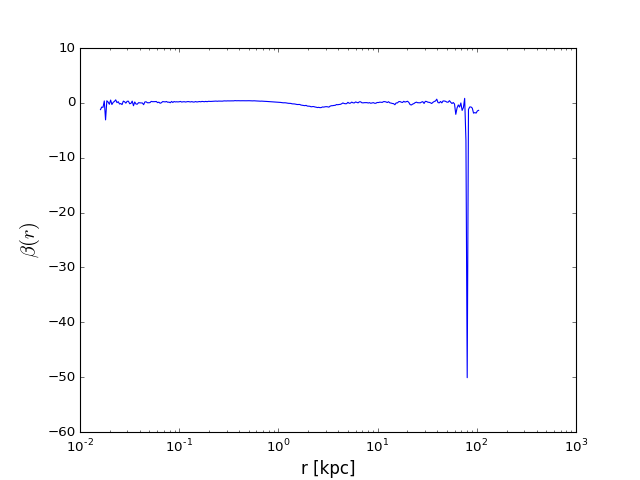

In [29]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xlabel("r [kpc]",fontsize=15)
ax.set_ylabel(r"$\beta(r)$",fontsize=18)
ax.plot((r_beta[1:]+r_beta[:-1])/2/10**0.8,beta_r)
#ax.axvline(x=myhalo.r200, color='k',linestyle='--',label=r'r$_{200}$')
#ax.axvline(x=myhalo.r97, color='gray',linestyle='--',label=r'r$_{97}$')
#ax.axvline(x=np.sqrt(r_nei2), color='g',linestyle='--',label=r'first neighbourg')
#legend = ax.legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
#frame = legend.get_frame()